In [125]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
results = pd.read_csv("../logs/preds/results.csv")
results

,Name,Overall Confidence,L1 Confidence,L1_target,L2_target,L1_preds,L2_preds
0,"Spot Shot Carpet Stain Remover, Instant (14 oz)",0.994688,0.999524,Household,Cleaning,Household,Cleaning
1,Nice! Premium Cold Brew Coffee Black Ready to ...,0.970077,0.994898,Drinks,Coffee,Drinks,Coffee
2,Burts Bees Baby Peach & Willow Bark Deep Pore ...,0.928978,0.946085,Personal Care,Facial Care,Baby & Child,Baby Food
3,Maybelline Great Lash Waterproof Mascara Very ...,0.999063,0.999561,Personal Care,Makeup,Personal Care,Makeup
4,Clairol Permanent Color Creme Matches Dark Aub...,0.994701,0.999090,Personal Care,Hair Care,Personal Care,Hair Care
...,...,...,...,...,...,...,...
9555,"Essential Everyday Sweet Corn, Whole Kernel (1...",0.869101,0.878816,Pantry,Canned Veggies,Pantry,Canned Veggies
9556,Wonka Theater Box Assorted (3.75 oz),0.814777,0.997404,Candy,Fruity,Candy,Fruity
9557,Walgreens Compact Tampons Regular Absorbency (...,0.996250,0.999356,Personal Care,Feminine,Personal Care,Feminine
9558,Walgreens Isopropyl Alcohol 91% Sprayer (10 oz),0.972467,0.993485,Medicine,First Aid,Medicine,First Aid


In [49]:
# Total accuracy = Overall Micro average F1 score
((results["L1_target"] == results["L1_preds"]) 
 & (results["L2_target"] == results["L2_preds"])).mean()

0.823744769874477

In [50]:
# L1 accuracy = L1's Micro average F1 score
(results["L1_target"] == results["L1_preds"]).mean()

0.9274058577405858

In [100]:
# L1 precision/recall
class_recalls = (results["L1_target"] == results["L1_preds"]).groupby(results["L1_target"]).mean()
class_precs = (results["L1_target"] == results["L1_preds"]).groupby(results["L1_preds"]).mean()

# frequency per class
class_frequencies = results.L1_target.value_counts() * 100 / len(results)

# combine
class_scores = pd.DataFrame({"Frequency": class_frequencies, "Recall": class_recalls, "Precision": class_precs})
class_scores.sort_values('Frequency', ascending=False)

,Frequency,Recall,Precision
Personal Care,20.564854,0.981180,0.964018
Pantry,15.742678,0.942857,0.907869
Household,9.048117,0.941040,0.962175
Drinks,8.033473,0.940104,0.930412
Snacks,7.960251,0.908016,0.885897
Vitamins,5.930962,0.932981,0.918403
Alcohol,5.460251,0.973180,0.994129
Frozen,5.345188,0.839530,0.884536
Dairy & Eggs,4.351464,0.918269,0.957393
Medicine,4.006276,0.812010,0.917404


In [79]:
# F1-scores
F1_scores = 2 / ((1 / class_scores["Recall"]) + (1 / class_scores["Precision"]))
F1_scores

Alcohol          0.983543
Baby & Child     0.851240
Bakery           0.867647
Candy            0.942657
Dairy & Eggs     0.937423
Drinks           0.935233
Fresh Food       0.545455
Frozen           0.861446
Household        0.951490
Meat & Fish      0.850633
Medicine         0.861496
Pantry           0.925033
Personal Care    0.972523
Pet Care         0.982456
Produce          0.880734
Snacks           0.896820
Vitamins         0.925634
dtype: float64

In [78]:
# Macro average F1 score
F1_scores.mean()

0.8924390355114707

In [53]:
# generate confusion matrix
# Understand the interaction between classes
confusion_matrix = pd.crosstab(results["L1_target"], results["L1_preds"], margins=True)

# Set indexes to class names 
confusion_matrix.index.name = "Actual"
confusion_matrix.columns.name = "Predicted"

# Normalize confusion matrix 
#normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)

confusion_matrix

Predicted,Alcohol,Baby & Child,Bakery,Candy,Dairy & Eggs,Drinks,Fresh Food,Frozen,Household,Meat & Fish,Medicine,Pantry,Personal Care,Pet Care,Produce,Snacks,Vitamins,All
Actual,,,,,,,,,,,,,,,,,,
Alcohol,508,0,0,0,0,11,0,1,1,0,0,1,0,0,0,0,0,522
Baby & Child,0,206,0,1,1,0,0,0,6,0,5,1,11,0,0,1,1,233
Bakery,0,0,177,1,1,1,2,7,1,1,0,11,0,0,0,9,0,211
Candy,0,3,0,337,0,0,0,1,1,0,0,4,1,0,1,10,2,360
Dairy & Eggs,0,0,0,1,382,6,2,4,0,2,0,9,1,0,0,9,0,416
Drinks,2,1,0,1,5,722,0,2,0,0,1,19,3,0,0,3,9,768
Fresh Food,0,0,1,0,3,0,36,7,0,9,0,10,0,1,4,7,0,78
Frozen,0,0,9,2,3,5,1,429,3,19,0,25,0,0,1,13,1,511
Household,0,13,1,3,1,4,0,2,814,0,1,3,20,0,0,3,0,865


Text(159.0, 0.5, 'Actual labels')

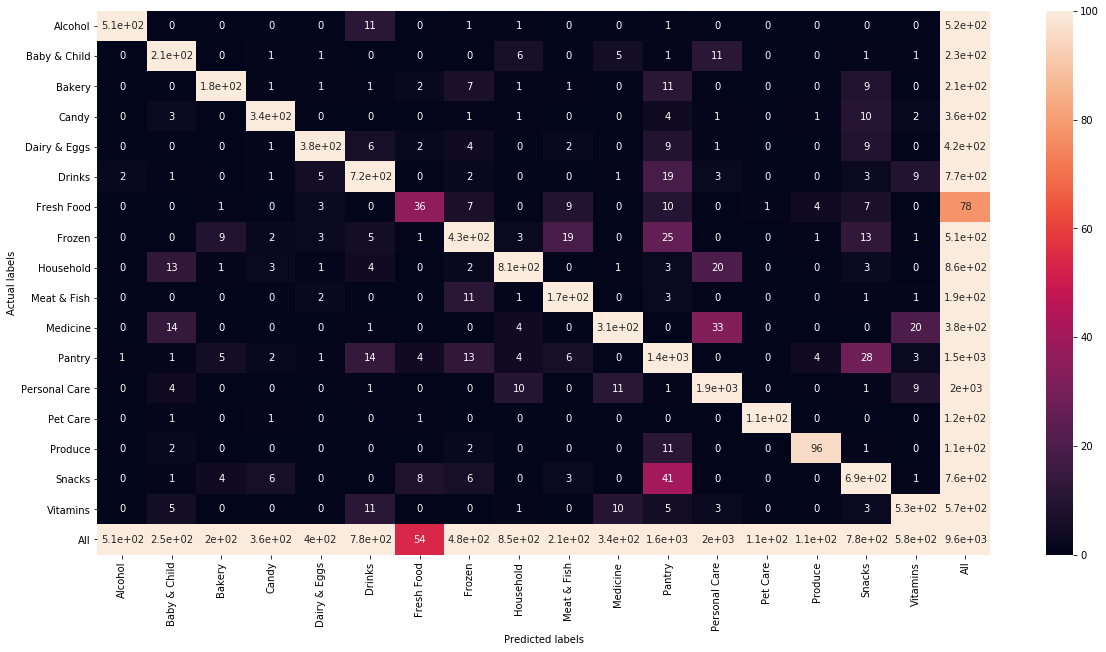

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(confusion_matrix, annot=True, ax=ax, vmin=0, vmax=100);

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels') 

In [68]:
# Check out lowest confidence predictions
low_confidence_results = results.sort_values('L1 Confidence', ascending=False)[-100:]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
print(low_confidence_results.to_string())

                                                                                                     Name  Overall Confidence  L1 Confidence      L1_target          L2_target       L1_preds             L2_preds
2144                                                                      Urbana Loofah in The Raw (1 oz)            0.095007       0.503524  Personal Care       Beauty Tools         Snacks             Crackers
8507                                                                     Guacamole Homestyle Tray (15 oz)            0.464915       0.500643         Snacks       Salsa & Dips         Snacks         Salsa & Dips
940                                                          Deli Fresh Fried Chicken Cold (8 ct / 56 oz)            0.363133       0.497949     Fresh Food        Quick Meals    Meat & Fish            Deli Meat
343                                                                           Diced Yellow Onions (10 oz)            0.320225       0.497603        Produce 

In [124]:
# L2 prec, recall
scores = ((results["L1_target"] == results["L1_preds"]) 
                 & (results["L2_target"] == results["L2_preds"]))
class_recalls = scores.groupby([results["L1_target"], results["L2_target"]]).mean()
class_precs = scores.groupby([results["L1_preds"], results["L2_preds"]]).mean()

# frequency per class
class_frequencies = results.groupby(["L1_target", "L2_target"]).size() * 100 / len(results)

# combine
class_scores = pd.DataFrame({
    "Frequency": class_frequencies, 
    "Recall": class_recalls, 
    "Precision": class_precs, 
})

sorted_class_scores = class_scores.sort_values('Frequency', ascending=False)
print(sorted_class_scores.to_string())

                                   Frequency    Recall  Precision
Personal Care Makeup                5.794979  0.958484   0.965455
              Hair Care             2.981172  0.933333   0.877888
Alcohol       Wine                  2.374477  0.982379   0.965368
Vitamins      Supplements           2.301255  0.681818   0.773196
Alcohol       Beer                  2.018828  0.958549   0.958549
Candy         Chocolate             1.893305  0.906077   0.916201
Household     Cleaning              1.809623  0.913295   0.827225
Snacks        Chips                 1.663180  0.867925   0.867925
Personal Care Facial Care           1.652720  0.879747   0.767956
Drinks        Juice                 1.569038  0.900000   0.849057
              Soda                  1.527197  0.924658   0.957447
Personal Care Oral Health           1.495816  0.937063   0.964029
              Bath & Body           1.495816  0.860140   0.897810
Pantry        Soup                  1.464435  0.935714   0.935714
          

In [99]:
sorted_class_scores = class_scores.sort_values('Recall', ascending=False)
print(sorted_class_scores.to_string())

                                   Frequency    Recall  Precision
Dairy & Eggs  Cream Cheese          0.073222  1.000000   1.000000
Pantry        Pasta Sauce           0.470711  1.000000   0.775862
Produce       Lettuce Mixes         0.146444  1.000000   0.666667
Dairy & Eggs  Eggs                  0.125523  1.000000   1.000000
Pet Care      Litter                0.104603  1.000000   1.000000
Fresh Food    Sushi                 0.062762  1.000000   0.857143
Household     Cards                 0.031381  1.000000   0.750000
              Clothing              0.355649  1.000000   0.971429
              Coffee Filters        0.020921  1.000000   1.000000
Bakery        Bagels                0.125523  1.000000   0.923077
Dairy & Eggs  Cottage Cheese        0.073222  1.000000   0.777778
Alcohol       Wine                  2.374477  0.982379   0.965368
Household     Fragrance             0.439331  0.976190   0.820000
Personal Care Nails                 0.857741  0.975610   0.941176
          